# 1. Import libraries 


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from matplotlib import pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import pandas_profiling as pp

# models
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier 
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, VotingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
df = pd.read_csv("cardio_train.csv",sep=";")
data=pd.read_csv("cardio_train.csv",sep=";")

/var/folders/7s/6mmnf_l55gv4lymz5yhwkd7r0000gn/T/ipykernel_22597/883631012.py:8: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling as pp


# 2. EDA & Feature Engineering

In [4]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


#### Univariate analysis
To understand all our variables, at first, we should look at their datatypes. We can do it with `info()` function:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


All features are numerical, 12 integers and 1 decimal number (weight). The second column gives us an idea how big is the dataset and how many non-null values are there for each field. We can use `describe()` to display sample statistics such as `min`, `max`, `mean`,`std` for each attribute:

In [6]:
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Age is measured in days, height is in centimeters. Let's look ate the numerical variables and how are they spread among target class. For example, at what age does the number of people with CVD exceed the number of people without CVD?

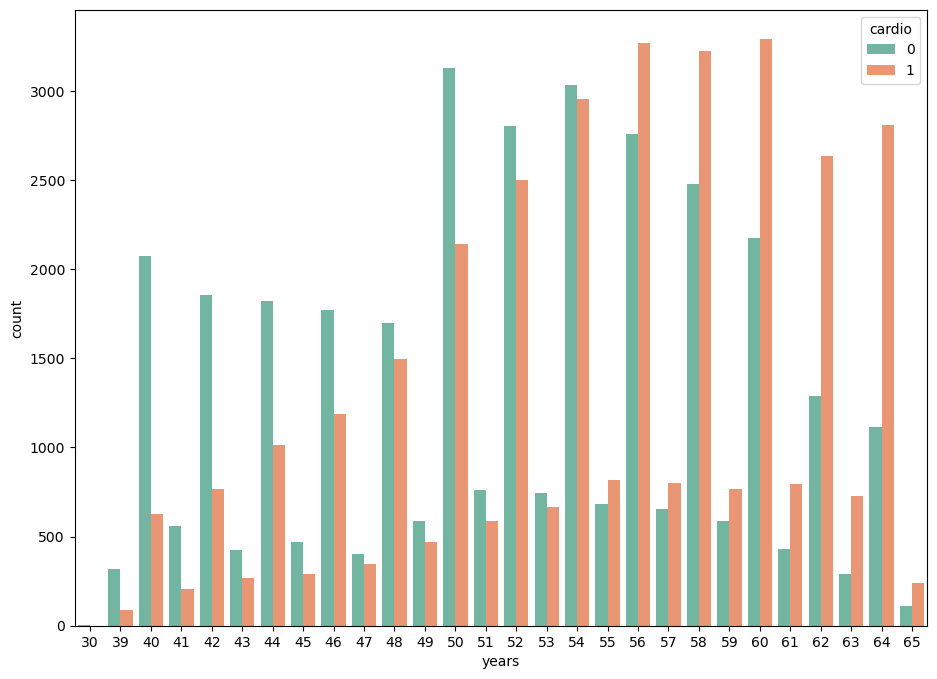

In [7]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
df['years'] = (df['age'] / 365).round().astype('int')
sns.countplot(x='years', hue='cardio', data = df, palette="Set2");

It can be observed that people over 55 of age are more exposed to CVD. From the table above, we can see that there are outliers in `ap_hi`, `ap_lo`, `weight` and `height`. We will deal with them later.

Let's look at categorical variables in the dataset and their distribution:

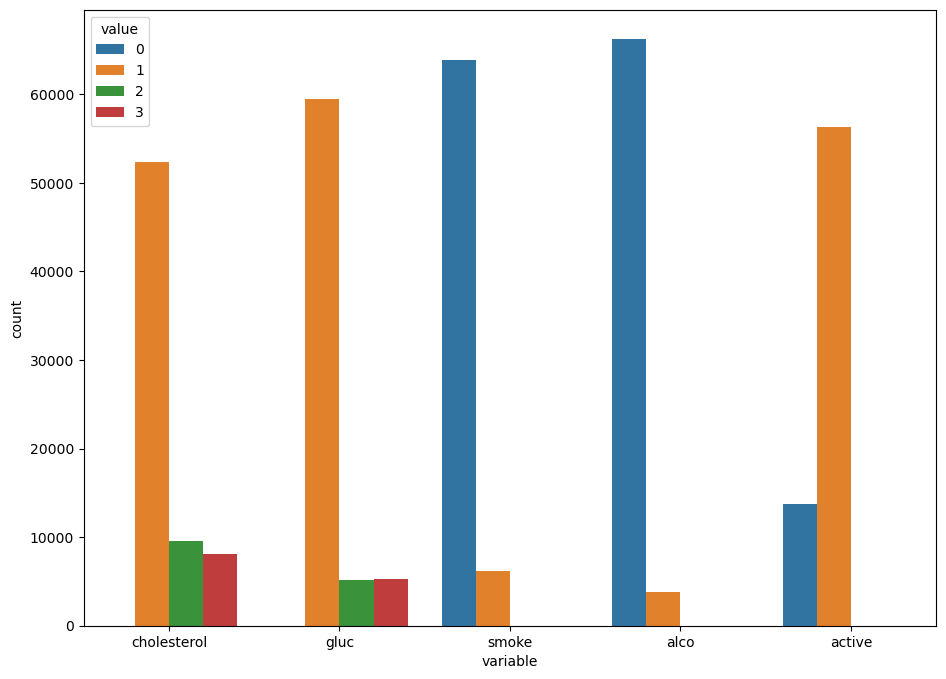

In [8]:
df_categorical = df.loc[:,['cholesterol','gluc', 'smoke', 'alco', 'active']]
sns.countplot(x="variable", hue="value",data= pd.melt(df_categorical));
target_name = 'cardio'

#### Bivariate analysis

It may be useful to split categorical variables by target class:

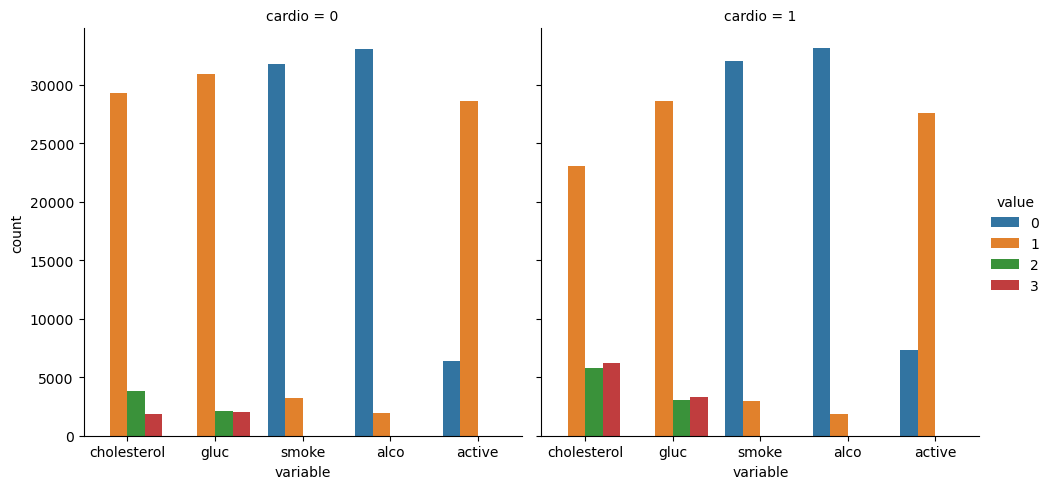

In [9]:
df_long = pd.melt(df, id_vars=['cardio'], value_vars=['cholesterol','gluc', 'smoke', 'alco', 'active'])
sns.catplot(x="variable", hue="value", col="cardio",
                data=df_long, kind="count");

It can be clearly seen that patients with CVD have higher cholesterol and blood glucose level. And, generally speaking less active.

To figure out whether "1" stands for women or men in gender column, let's calculate the mean of height per gender. We assume that men are higher than women on average.

In [10]:
df.groupby('gender')['height'].mean()

gender
1    161.355612
2    169.947895
Name: height, dtype: float64

Average height for "2" gender is greater, than for "1" gender, therefore "1" stands for women. Let's see how many men and women presented in the dataset:

In [11]:
df['gender'].value_counts()

1    45530
2    24470
Name: gender, dtype: int64

Who more often report consuming alcohol - men or women?

In [12]:
df.groupby('gender')['alco'].sum()

gender
1    1161
2    2603
Name: alco, dtype: int64

So, men consume alcohol more frequently on average. 
Next, the target variables are balanced:`

In [13]:
df['cardio'].value_counts(normalize=True)

0    0.5003
1    0.4997
Name: cardio, dtype: float64

To see how the target class is distributed among men and women, we can use also `crosstab`

In [14]:
pd.crosstab(df['cardio'],df['gender'],normalize=True)

gender,1,2
cardio,,
0,0.327343,0.172957
1,0.323086,0.176614


### Cleaning Data

Are there any `NA`s or missing values in a dataset?

In [15]:
df.isnull().values.any()

False

If we look more closely to height and weight columns, we will notice that minimum height is 55 cm and minimum weight is 10 kg. That has to be an error, since minimum age is 10798 days, which equals to 29 years. On the other hand, the maximum height is 250 cm and the highest weight is 200 kg, which might be irrelevant, when generilizing data. To deal with these errors, we can remove outliers.

In [16]:
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,years
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700,53.338686
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003,6.765294
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,30.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,48.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,54.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,58.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,65.000000


Let's remove weights and heights, that fall below 2.5% or above 97.5% of a given range.

In [17]:
df.drop(df[(df['height'] > df['height'].quantile(0.975)) | (df['height'] < df['height'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['weight'] > df['weight'].quantile(0.975)) | (df['weight'] < df['weight'].quantile(0.025))].index,inplace=True)

In addition, in some cases diastolic pressure is higher than systolic, which is also  incorrect. How many records are inaccurate in terms of blood pressure?

In [18]:
print("Diastilic pressure is higher than systolic one in {0} cases".format(df[df['ap_lo']> df['ap_hi']].shape[0]))

Diastilic pressure is higher than systolic one in 1082 cases


Let's get rid of the outliers, moreover blood pressure could not be negative value!

In [19]:
df.drop(df[(df['ap_hi'] > df['ap_hi'].quantile(0.975)) | (df['ap_hi'] < df['ap_hi'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['ap_lo'] > df['ap_lo'].quantile(0.975)) | (df['ap_lo'] < df['ap_lo'].quantile(0.025))].index,inplace=True)

Diastilic pressure is higher than systolic one in 0 cases


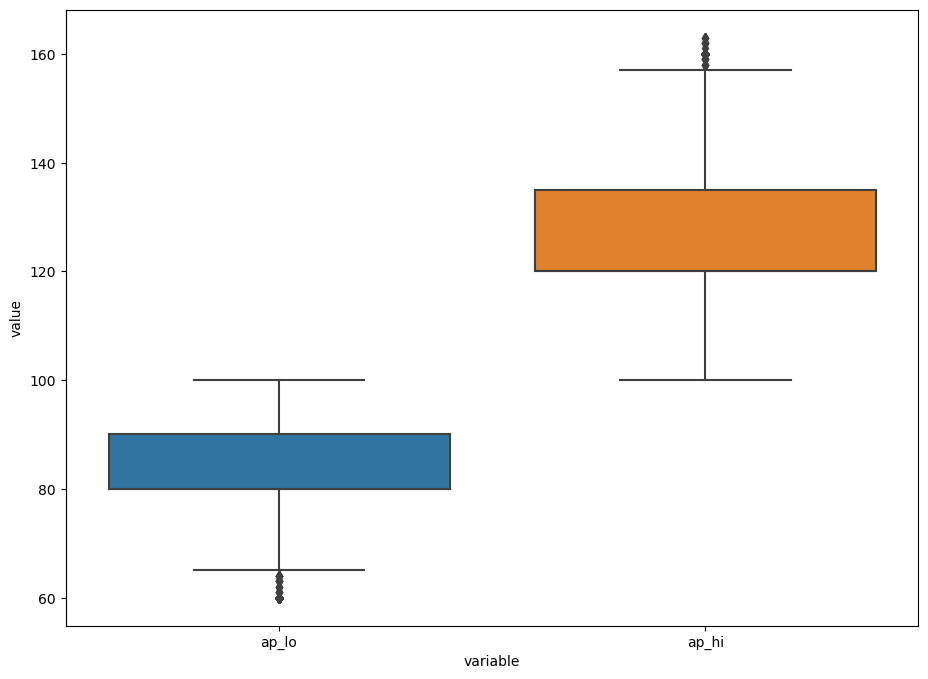

In [20]:
blood_pressure = df.loc[:,['ap_lo','ap_hi']]
sns.boxplot(x = 'variable',y = 'value',data = blood_pressure.melt())
print("Diastilic pressure is higher than systolic one in {0} cases".format(df[df['ap_lo']> df['ap_hi']].shape[0]))

#### Multivariate analysis
It might be useful to consider correation matrix:

/var/folders/7s/6mmnf_l55gv4lymz5yhwkd7r0000gn/T/ipykernel_22597/988597964.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


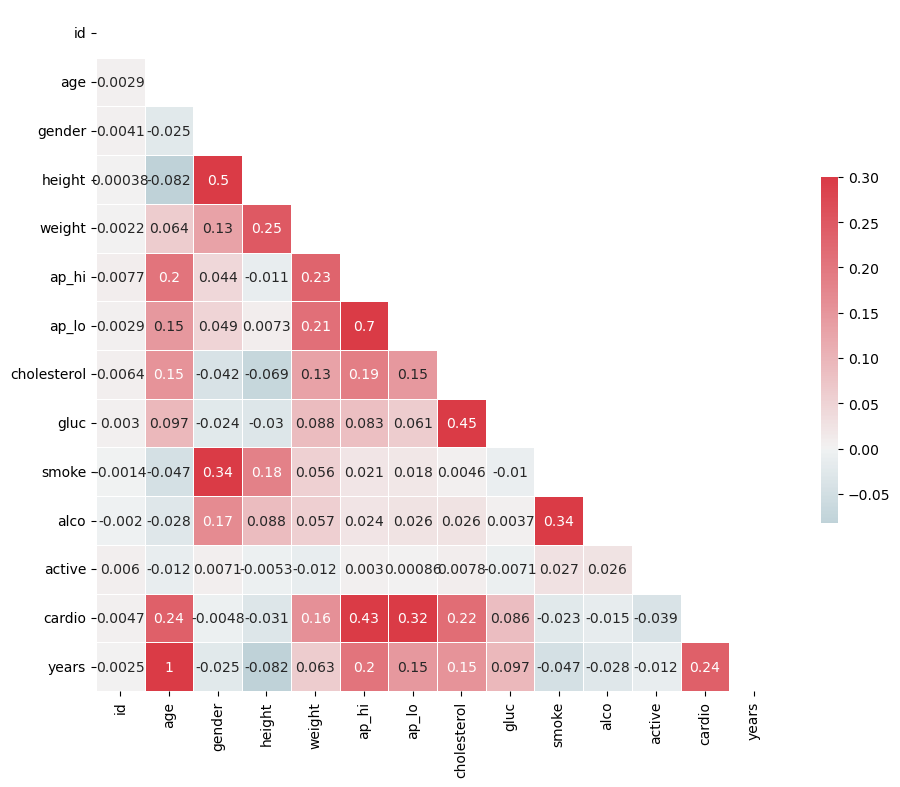

In [21]:
corr = df.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

As we can see age and cholesterol have significant impact, but not very high correlated with target class.

Let's create `violinplot` to show height distribution across gender. Looking at the mean values of height and weight for each value of the gender feature might not be enough to determin whether 1 is male or female designation.

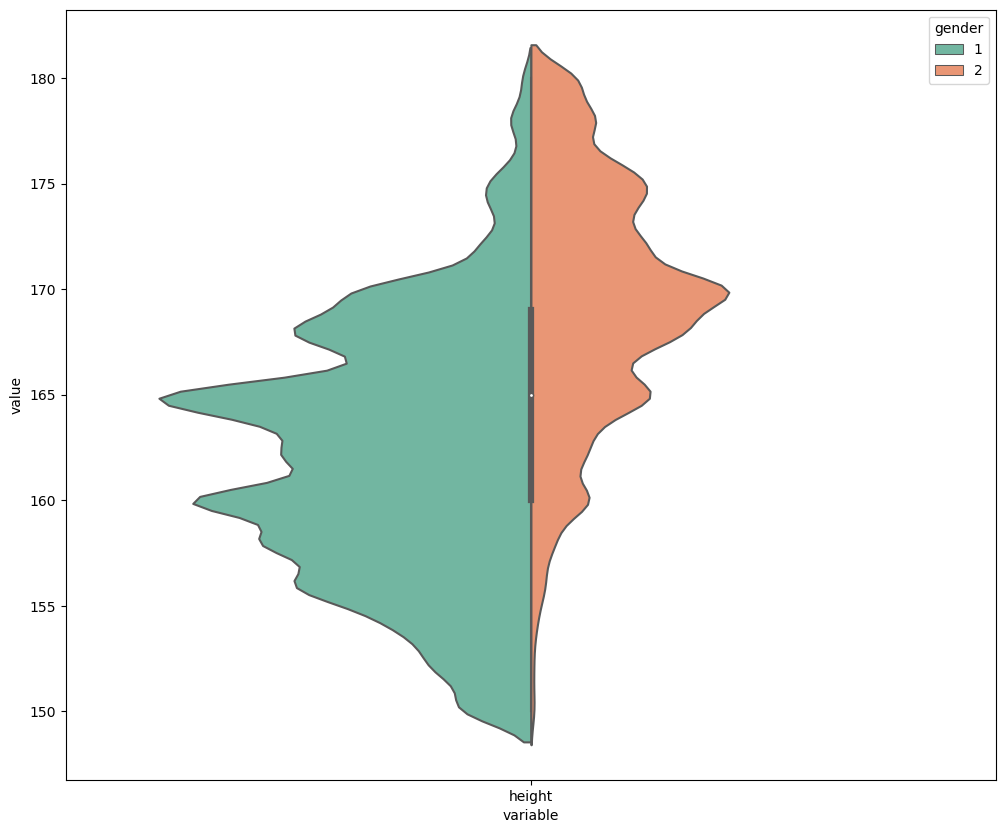

In [22]:
import warnings
warnings.filterwarnings("ignore")
df_melt = pd.melt(frame=df, value_vars=['height'], id_vars=['gender'])
plt.figure(figsize=(12, 10))
ax = sns.violinplot(
    x='variable', 
    y='value', 
    hue='gender', 
    split=True, 
    data=df_melt, 
    scale='count',
    scale_hue=False,
    palette="Set2");

Let's create a new feature - Body Mass Index (BMI):

$$BMI = \frac {mass_{kg}} {height ^2_{m}},$$

and compare average BMI for healthy people to average BMI of ill people. Normal BMI values are said to be from 18.5 to 25.

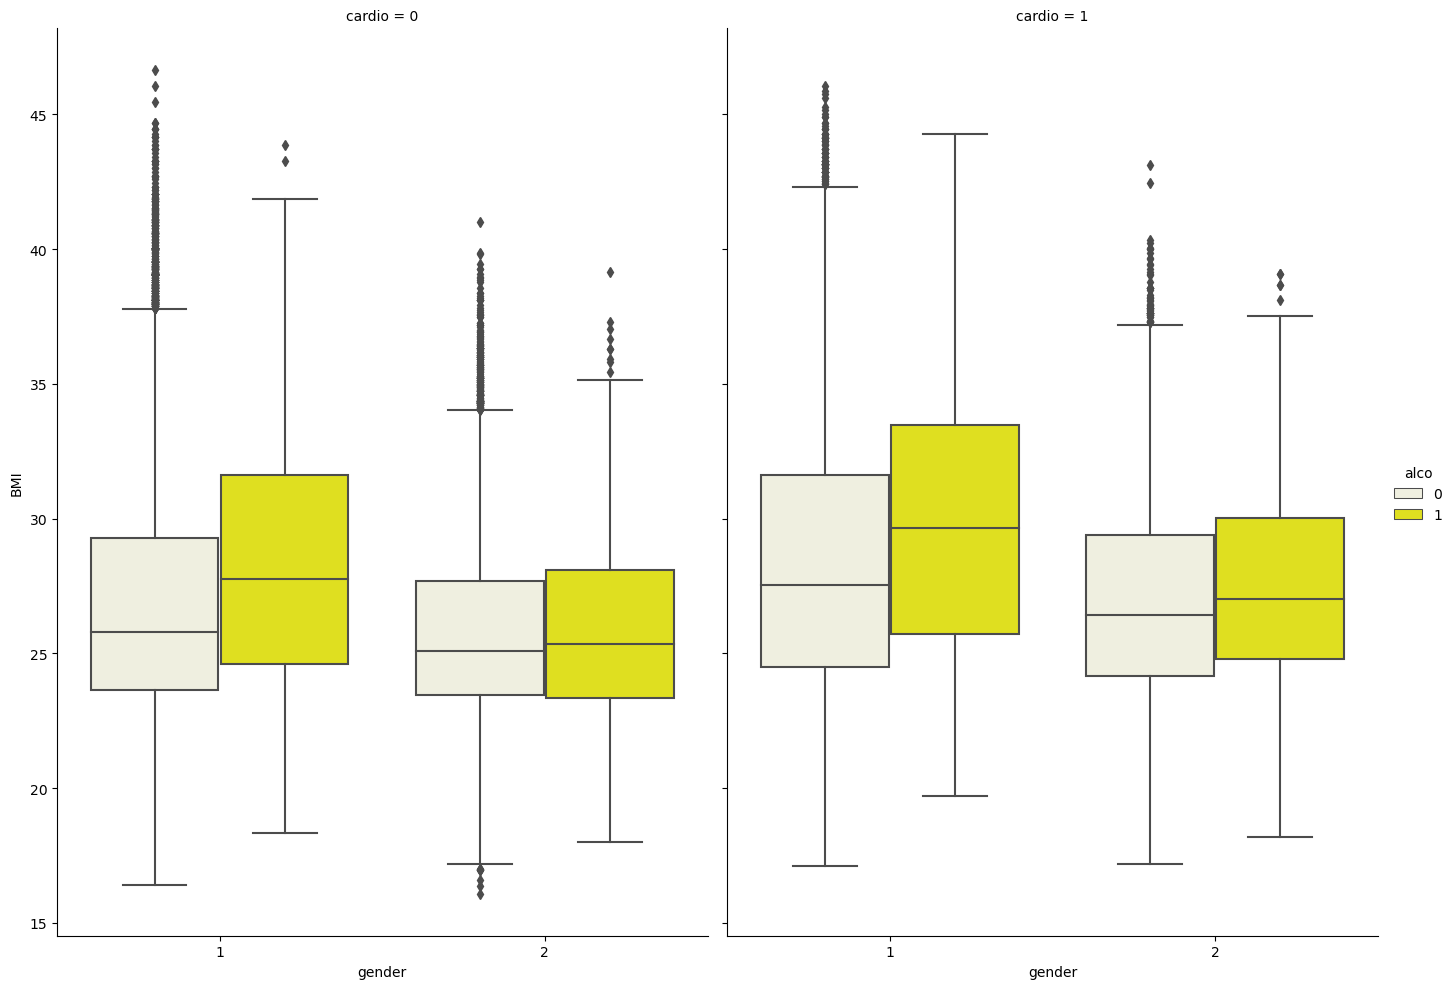

In [23]:
df['BMI'] = df['weight']/((df['height']/100)**2)
sns.catplot(x="gender", y="BMI", hue="alco", col="cardio", data=df, color = "yellow",kind="box", height=10, aspect=.7);

 Drinking women have higher risks for CVD than drinking men based on thier BMI.

*To be continued*

In [24]:
data.drop("id",axis=1,inplace=True)
data.drop_duplicates(inplace=True)
data["bmi"] = data["weight"] / (data["height"]/100)**2
out_filter = ((data["ap_hi"]>250) | (data["ap_lo"]>200))
data = data[~out_filter]
len(data)

68983

In [25]:
out_filter2 = ((data["ap_hi"] < 0) | (data["ap_lo"] < 0))
data = data[~out_filter2]
data.head(5)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.011177


In [26]:

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68975 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          68975 non-null  int64  
 1   gender       68975 non-null  int64  
 2   height       68975 non-null  int64  
 3   weight       68975 non-null  float64
 4   ap_hi        68975 non-null  int64  
 5   ap_lo        68975 non-null  int64  
 6   cholesterol  68975 non-null  int64  
 7   gluc         68975 non-null  int64  
 8   smoke        68975 non-null  int64  
 9   alco         68975 non-null  int64  
 10  active       68975 non-null  int64  
 11  cardio       68975 non-null  int64  
 12  bmi          68975 non-null  float64
dtypes: float64(2), int64(11)
memory usage: 7.4 MB


In [27]:
pp.ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# 3. Analyzing the models

In [28]:
target_name = 'cardio'
data_target = data[target_name]
data = data.drop([target_name], axis=1)
train, test, target, target_test = train_test_split(data, data_target, test_size=0.2, random_state=0)
X_train,x_test ,Y_train, y_test = train_test_split(data, data_target, test_size=0.2, random_state=0)

## 3.1 Logistic Regression

In [29]:
from sklearn.metrics import accuracy_score
logreg = LogisticRegression()
logreg.fit(train, target)
y_pred = logreg.predict(test)
accuracy = accuracy_score(target_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7193910837259877


## 3.2 Support vector machine 

In [30]:
svc = SVC()
svc.fit(train, target)
y_pred = svc.predict(test)
accuracy = accuracy_score(target_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5940558173251178


## 3.3 Linear SVM

In [31]:
lsvc = LinearSVC()
lsvc.fit(train, target)
y_pred = lsvc.predict(test)
accuracy = accuracy_score(target_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5110547299746285


## 3.4 KNN

In [32]:
knn=KNeighborsClassifier()
knn.fit(train, target)
y_pred = knn.predict(test)
accuracy = accuracy_score(target_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6842334179050381


## 3.5 Naive Bayes 

In [33]:
nb=GaussianNB()
nb.fit(train, target)
y_pred = nb.predict(test)
accuracy = accuracy_score(target_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7026458861906488


## 3.6 Perceptron 

In [34]:
p=Perceptron()
p.fit(train, target)
y_pred = p.predict(test)
accuracy = accuracy_score(target_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6258789416455237


## 3.7 Stochastic Gradient Descent 

In [35]:
sgd=SGDClassifier()
sgd.fit(train, target)
y_pred = sgd.predict(test)
accuracy = accuracy_score(target_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7064153678869155


## 3.8 Decision Tree Classifier 

In [36]:
dt=DecisionTreeClassifier()
dt.fit(train, target)
y_pred = dt.predict(test)
accuracy = accuracy_score(target_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6417542587894165


## 3.9 Random Forests  

In [37]:
rfc=RandomForestClassifier()
rfc.fit(train, target)
y_pred = rfc.predict(test)
accuracy = accuracy_score(target_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7156216020297209


## 3.10 XGB Classifier  

In [38]:
xg=xgb.XGBClassifier()
xg.fit(train, target)
y_pred = xg.predict(test)
accuracy = accuracy_score(target_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7335266400869881


## 3.11 GradientBoostingClassifier  

In [39]:
gbc=GradientBoostingClassifier()
gbc.fit(train, target)
y_pred = gbc.predict(test)
accuracy = accuracy_score(target_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.738310982239942


## 3.12 AdaBoost Classifier 

In [40]:
ad=AdaBoostClassifier()
ad.fit(train, target)
y_pred = ad.predict(test)
accuracy = accuracy_score(target_test, y_pred)
print("Accuracy:", accuracy)
train.head(3)

Accuracy: 0.7328017397607829


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi
31684,21263,2,160,76.0,130,80,1,1,0,1,1,29.687500
5634,14684,2,184,70.0,120,80,1,1,0,0,1,20.675803
58675,23436,1,158,76.0,120,80,1,1,0,0,1,30.443839


# 4. Hyper-parameter Optimization

In [47]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_classification
from scipy.stats import randint as sp_randint
gb_classifier = GradientBoostingClassifier(random_state=42)
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': sp_randint(100, 1000),
    'max_depth': sp_randint(1, 10),
    'min_samples_split': sp_randint(2, 20),
    'min_samples_leaf': sp_randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

# Perform randomized search cross-validation
random_search = RandomizedSearchCV(
    estimator=gb_classifier,
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings to sample
    scoring='accuracy',  # Evaluation metric
    cv=5,  # Number of cross-validation folds
    random_state=42
)
random_search.fit(train, target)

# Get the best model
best_model = random_search.best_estimator_

# Predict on the test set
predictions = best_model.predict(test)

# Calculate accuracy score
accuracy = accuracy_score(target_test, predictions)
print("Accuracy Score:", accuracy)

Accuracy Score: 0.7382384922073215


In [48]:
j=[[0,2,160,76.0,130,80,0,0,0,1,1,29.687500]]
best_model.predict(j)

array([0])

# 5. Saving our model

In [49]:
import pickle

# Assuming you have a trained model stored in the variable 'model'
# Pickle the model
with open('adaboost.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [50]:
with open('adaboost.pkl', 'rb') as f:
    model = pickle.load(f)
model.predict(j)

array([0])